# Get the Data

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [301]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [302]:
#MY_OPTIMIZER = "SGD"
MY_EPOCHS = 200
MY_LEARNING_RATE = 0.0001

# Get the Data

In [303]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(1230, 8)

In [304]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1230.000000,1.230000e+03,1.230000e+03,1.230000e+03,1.230000e+03,1.230000e+03,1.230000e+03,1.230000e+03
mean,1889.072429,-9.916647e-01,4.966089e-08,8.983599e-04,1.013617e-08,9.931018e-03,-2.791437e-08,1.678578e-11
std,1086.682334,6.347890e-10,4.377754e-08,3.185244e-09,8.940185e-09,2.167380e-09,2.451461e-08,8.777943e-13
min,9.177680,-9.916647e-01,-8.264015e-11,8.983543e-04,-1.957939e-11,9.931014e-03,-8.232560e-08,1.418637e-11
25%,949.125054,-9.916647e-01,9.850175e-09,8.983570e-04,2.009559e-09,9.931016e-03,-4.677537e-08,1.620357e-11
50%,1889.072429,-9.916647e-01,3.771331e-08,8.983599e-04,7.699809e-09,9.931018e-03,-2.129590e-08,1.676455e-11
75%,2829.019804,-9.916647e-01,8.355092e-08,8.983626e-04,1.705206e-08,9.931020e-03,-5.693426e-09,1.734733e-11
max,3768.967179,-9.916647e-01,1.468071e-07,8.983653e-04,2.997673e-08,9.931022e-03,-5.776291e-12,2.054861e-11


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [305]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)


# Prepare the Data for Machine Learning Algorithms

In [306]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()


# Convert dataframe to a numpy array before training, to avoid issues with dataframe headers.
maneuvers_predictors = maneuvers_predictors.to_numpy()
maneuvers_labels = maneuvers_labels.to_numpy()

#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test/Validation Set

In [307]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
#X_train.head()

(738, 6)
(246, 6)
(246, 6)


In [308]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.2643609 , 0.55178027, 0.75484263, 0.5517429 , 0.72421204,
        0.44773778],
       [0.69560772, 0.09924712, 0.31241436, 0.09931666, 0.29971706,
        0.89885213],
       [0.26663178, 0.5479178 , 0.75141634, 0.5479093 , 0.72248683,
        0.45113835],
       [0.88915199, 0.01474045, 0.10918916, 0.0147396 , 0.11191188,
        0.98367122],
       [0.6382727 , 0.140205  , 0.37790104, 0.1400636 , 0.35217789,
        0.85956191]])

In [309]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)

In [310]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [311]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 300)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

In [312]:
opt = keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS,
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2768 - val_loss: 0.2894
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2713 - val_loss: 0.2802
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2622 - val_loss: 0.2715
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2597 - val_loss: 0.2631
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2523 - val_loss: 0.2549
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2401 - val_loss: 0.2471
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2382 - val_loss: 0.2393
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2379 - val_loss: 0.2320
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2255 - val_loss: 0.2250
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2118 - val_loss: 0.2180
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2120 - val_loss: 0.2113
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535 - val_loss: 0.0597
Epoch 70/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0524 - val_loss: 0.0591
Epoch 71/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527 - val_loss: 0.0584
Epoch 72/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - val_loss: 0.0578
Epoch 73/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0475 - val_loss: 0.0572
Epoch 74/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0485 - val_loss: 0.0567
Epoch 75/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0473 - val_loss: 0.0561
Epoch 76/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - val_loss: 0.0556
Epoch 77/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - val_loss: 0.0551
Epoch 78/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - val_loss: 0.0546
Epoch 79/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477 - val_loss: 0.0541
Epoch 80/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0429 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 - val_loss: 0.0434
Epoch 138/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360 - val_loss: 0.0434
Epoch 139/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0365 - val_loss: 0.0433
Epoch 140/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331 - val_loss: 0.0433
Epoch 141/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341 - val_loss: 0.0432
Epoch 142/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0346 - val_loss: 0.0432
Epoch 143/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0359 - val_loss: 0.0432
Epoch 144/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351 - val_loss: 0.0431
Epoch 145/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372 - val_loss: 0.0431
Epoch 146/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 - val_loss: 0.0430
Epoch 147/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0332 - val_loss: 0.0430
Epoch 148/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

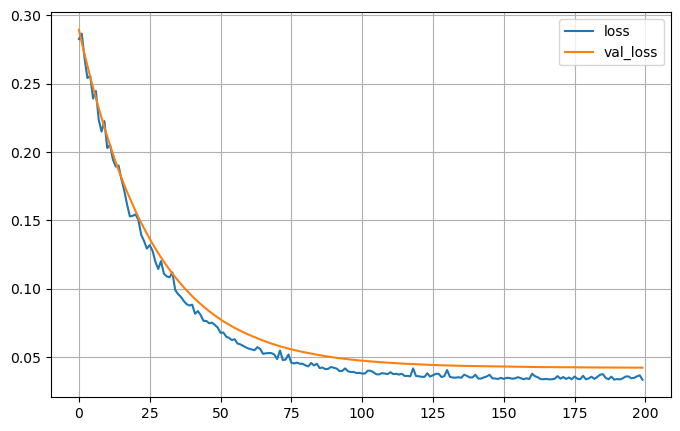

In [313]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [314]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0330 


0.17910400272483315

In [315]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [316]:
y_test_scaled[:3]

array([[0.81333547],
       [0.29848715],
       [0.45441447]])

In [317]:
y_pred[:3]

array([[0.5113389 ],
       [0.5314889 ],
       [0.56214887]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [318]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE),
        #optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [319]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_21, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [320]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [321]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [322]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 20 Complete [00h 00m 36s]
val_loss: 0.04291703179478645

Best val_loss So Far: 0.04180794022977352
Total elapsed time: 00h 10m 25s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [323]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        36,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,745 (155.25 KB)

 Trainable params: 39,745 (155.25 KB)

 Non-trainable params: 0 (0.00 B)

In [324]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
num_layers: 2
units_0: 384
units_1: 96
units_2: 480
units_3: 96
units_4: 160
Score: 0.04180794022977352

Trial 07 summary
Hyperparameters:
num_layers: 4
units_0: 128
units_1: 288
units_2: 448
units_3: 64
units_4: 352
Score: 0.041855137795209885

Trial 12 summary
Hyperparameters:
num_layers: 2
units_0: 416
units_1: 352
units_2: 512
units_3: 160
units_4: 32
Score: 0.0419212281703949

Trial 18 summary
Hyperparameters:
num_layers: 3
units_0: 448
units_1: 224
units_2: 288
units_3: 288
units_4: 64
Score: 0.04204573109745979

Trial 11 summary
Hyperparameters:
num_layers: 2
units_0: 256
units_1: 256
units_2: 288
units_3: 160
units_4: 128
Score: 0.042222125455737114

Trial 16 summary
Hyperparameters:
num_layers: 4
units_0: 192
units_1: 256
units_2: 448
units_3: 384
units_4: 480
Score: 0.04223255068063736

Trial 09 summary
Hyperparameters:
num_layers:

In [325]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 


0.17984068601966147

In [326]:
X_new = X_test_scaled[:10] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [327]:
y_test_scaled[:10]

array([[0.81333547],
       [0.29848715],
       [0.45441447],
       [0.53289842],
       [0.52361322],
       [0.63951813],
       [0.56347555],
       [0.49595774],
       [0.39181942],
       [0.57292084]])

In [328]:
y_pred[:10]

array([[0.53751785],
       [0.5476409 ],
       [0.5377469 ],
       [0.5258452 ],
       [0.53234875],
       [0.54827744],
       [0.5281929 ],
       [0.534084  ],
       [0.52566844],
       [0.534456  ]], dtype=float32)

In [329]:
best_model.save("best_model.keras")